In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [2]:
#STEP 1: Install & Import Required Libraries
!pip install -q seaborn scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [3]:
 #STEP2: Define Directories
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'


In [4]:
#STEP 4: Build the InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 output classes
model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#STEP 5: Freeze Base Model and Compile
base_model.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#STEP 6: Data Augmentation and Loaders
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [ ]:
#  STEP 7: Train Top Layers
model.fit(train_generator, epochs=5, validation_data=val_generator)



Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 888s 12s/step - accuracy: 0.9733 - loss: 0.0883 - val_accuracy: 0.8534 - val_loss: 0.4228
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 918s 13s/step - accuracy: 0.9767 - loss: 0.0811 - val_accuracy: 0.8499 - val_loss: 0.4407
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 868s 12s/step - accuracy: 0.9677 - loss: 0.1011 - val_accuracy: 0.8586 - val_loss: 0.4345
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 863s 12s/step - accuracy: 0.9717 - loss: 0.0867 - val_accuracy: 0.8534 - val_loss: 0.4057
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 862s 12s/step - accuracy: 0.9830 - loss: 0.0730 - val_accuracy: 0.8551 - val_loss: 0.4156


In [ ]:
#STEP 8: Unfreeze for Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# STEP 9: Callbacks
checkpoint = ModelCheckpoint("inceptionv3_finetuned.h5", monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

In [ ]:
#10: Fine-Tune & Save History
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, lr_scheduler]
)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8611 - loss: 0.3776

72/72 ━━━━━━━━━━━━━━━━━━━━ 873s 12s/step - accuracy: 0.8612 - loss: 0.3771 - val_accuracy: 0.7382 - val_loss: 0.6358 - learning_rate: 1.0000e-05
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8948 - loss: 0.2776

72/72 ━━━━━━━━━━━━━━━━━━━━ 918s 12s/step - accuracy: 0.8949 - loss: 0.2776 - val_accuracy: 0.7923 - val_loss: 0.5195 - learning_rate: 1.0000e-05
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9233 - loss: 0.2483

72/72 ━━━━━━━━━━━━━━━━━━━━ 868s 12s/step - accuracy: 0.9233 - loss: 0.2480 - val_accuracy: 0.7993 - val_loss: 0.5114 - learning_rate: 1.0000e-05
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9372 - loss: 0.1887

72/72 ━━━━━━━━━━━━━━━━━━━━ 860s 12s/step - accuracy: 0.9372 - loss: 0.1887 - val_accuracy: 0.8307 - val_loss: 0.4771 - learning_rate: 1.0000e-05
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9459 - loss: 0.1729

72/72 ━━━━━━━━━━━━━━━━━━━━ 864s 12s/step - accuracy: 0.9459 - loss: 0.1729 - val_accuracy: 0.8342 - val_loss: 0.4753 - learning_rate: 1.0000e-05
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9599 - loss: 0.1488

72/72 ━━━━━━━━━━━━━━━━━━━━ 871s 12s/step - accuracy: 0.9599 - loss: 0.1487 - val_accuracy: 0.8412 - val_loss: 0.4468 - learning_rate: 1.0000e-05
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 864s 12s/step - accuracy: 0.9483 - loss: 0.1417 - val_accuracy: 0.8325 - val_loss: 0.4268 - learning_rate: 1.0000e-05
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9695 - loss: 0.1133

72/72 ━━━━━━━━━━━━━━━━━━━━ 915s 13s/step - accuracy: 0.9695 - loss: 0.1133 - val_accuracy: 0.8447 - val_loss: 0.4237 - learning_rate: 1.0000e-05
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9542 - loss: 0.1253

72/72 ━━━━━━━━━━━━━━━━━━━━ 918s 13s/step - accuracy: 0.9543 - loss: 0.1252 - val_accuracy: 0.8482 - val_loss: 0.4437 - learning_rate: 1.0000e-05
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9706 - loss: 0.1087


Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
72/72 ━━━━━━━━━━━━━━━━━━━━ 860s 12s/step - accuracy: 0.9706 - loss: 0.1086 - val_accuracy: 0.8674 - val_loss: 0.4254 - learning_rate: 1.0000e-05


In [ ]:
#STEP 11: Test Evaluation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



Found 394 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step


In [ ]:
#STEP 12: Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))



Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.68      1.00      0.81       115
        no_tumor       0.70      0.98      0.82       105
 pituitary_tumor       0.93      0.77      0.84        74

        accuracy                           0.74       394
       macro avg       0.83      0.73      0.69       394
    weighted avg       0.82      0.74      0.69       394



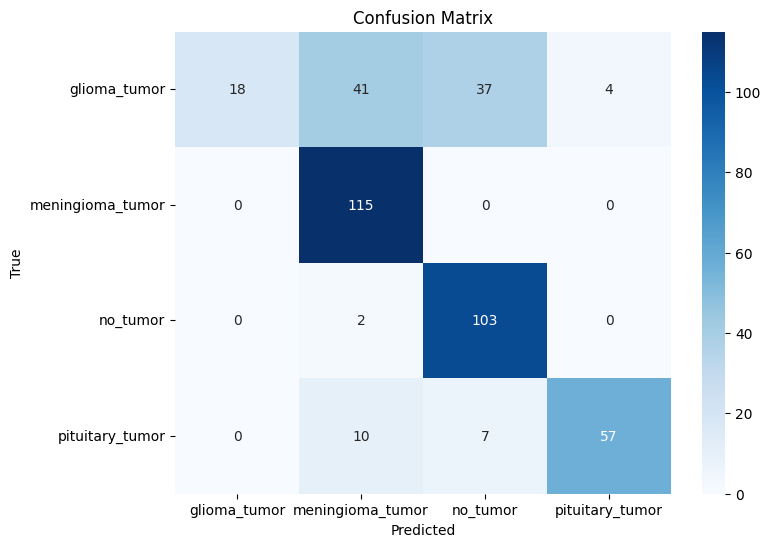

In [ ]:
# STEP 13: Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



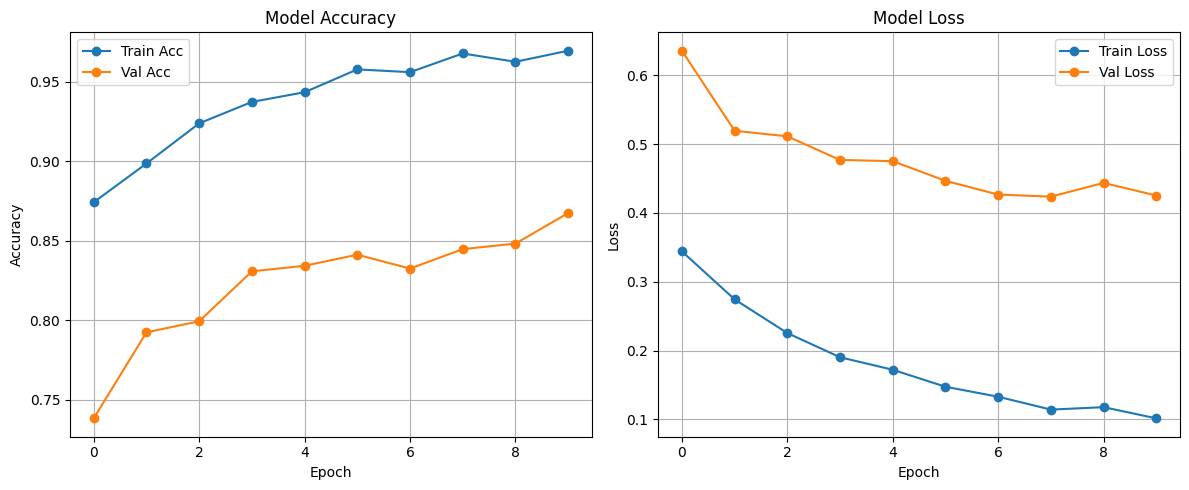

In [ ]:
# STEP 14: Visualization - Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


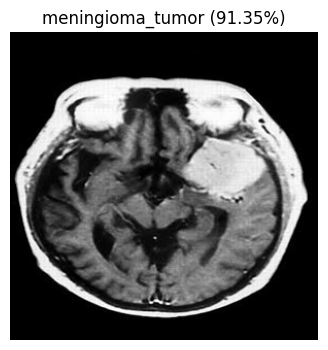

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


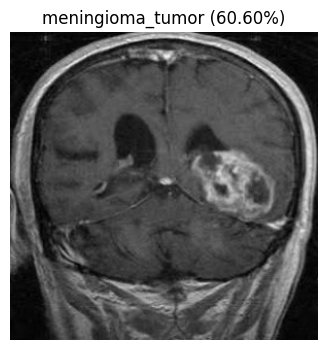

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


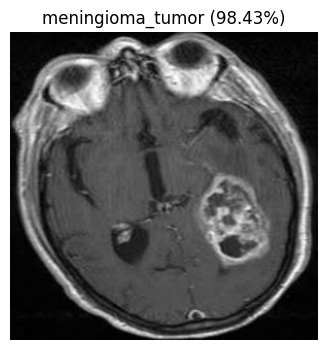

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


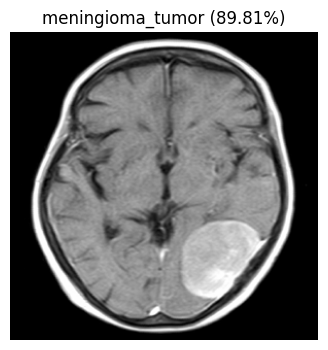

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


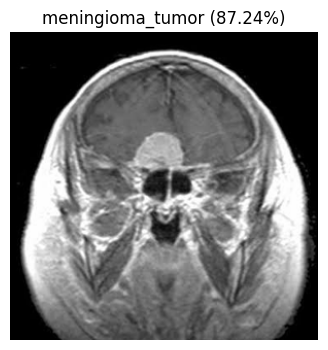

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


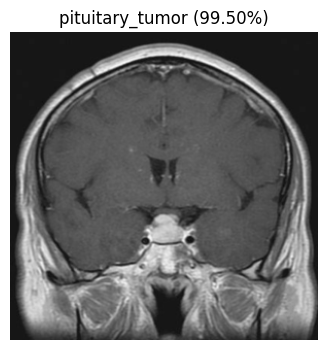

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_multiple_local(images_list):
    for idx, img_path in enumerate(images_list):
        try:
            # Load and preprocess the image
            img = Image.open(img_path).convert('RGB')
            img = img.resize((299, 299))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # Predict
            pred = model.predict(img_array)
            predicted_class = np.argmax(pred)
            confidence = np.max(pred)

            # Display
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{class_labels[predicted_class]} ({confidence*100:.2f}%)")
            plt.show()

        except Exception as e:
            print(f"⚠️ Could not process image {idx + 1}: {img_path}")
            print(f"Reason: {e}")

# ✅ Replace with local image paths from your Kaggle dataset
image_paths = [
    "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(107).jpg","/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(11).jpg",
    "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(10).jpg","/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(126).jpg",
    "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(38).jpg","/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(10).jpg"
]

predict_multiple_local(image_paths)


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

# Make sure `model` is your trained model, and `class_labels` are defined
def predict_image(img: Image.Image):
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred)
    confidence = np.max(pred)

    return {class_labels[predicted_class]: float(confidence)}

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title="🧠 Brain Tumor Classification",
    description="Upload an MRI image and the model will predict the tumor type: Glioma, Meningioma, Pituitary, or No Tumor."
)

interface.launch(share=True)  # use share=True to get a public URL


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b14a4d00f43f793875.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
